# Traffic Sign Classification with Keras and CNN

Use the German Traffic Sign dataset to classify traffic sign images.

## Load the data 

In [10]:
import pickle
from pathlib import Path
import numpy as np
import math
import csv

training_file = '/data/traffic-signs-data/train.p'
validation_file = '/data/traffic-signs-data/valid.p' 
testing_file = '/data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

#load mappings from label number to label name
signNames = {}
with open('/data/traffic-signs-data/sign_names.csv') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
         signNames[row['ClassId']]=row['SignName']
 

## Data Set Exploration

### Basic statistics

In [11]:
n_train = len(x_train)
n_validation = len(x_valid)
n_test = len(x_test)

image_shape = x_train[0].shape

# Number of unique labels/classes
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Detailed Date Set Exploration

Explore the data as you see fit. 

Try to answer questions like:
* is there a skew in class distribution?
* what do images look like?
* do you notice anything peculiar with the data?

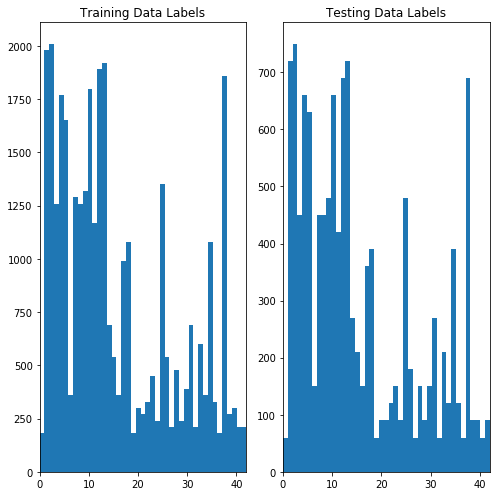

In [12]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,7)

#visualize label distribution
plt.subplot(1,2,1).hist(y_train,43);
plt.xlim(0,42)
plt.title('Training Data Labels');
plt.subplot(1,2,2).hist(y_test,43);
plt.title('Testing Data Labels');
plt.xlim(0,42)
plt.tight_layout();

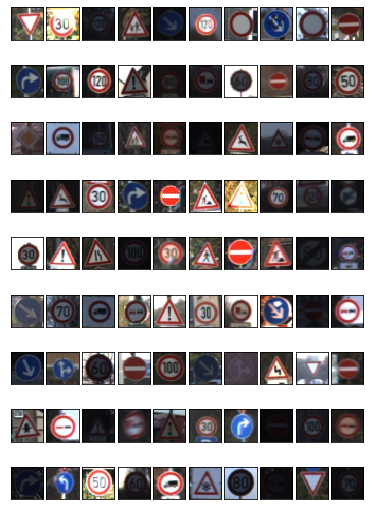

In [13]:
#visualize training data images
plt.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.1)

def get_random_images(images, how_many):
     rnd = random.sample(range(len(x_train)), how_many)
     return images[rnd]   

def plot_images(images, rows, cols):
    """Samples images randomly"""
    gs = gridspec.GridSpec(rows, cols, top=1.0, bottom=.0, right=.7, left=0., hspace=0.3,
                           wspace=0.1)

    for index, g in enumerate(gs):
        ax = plt.subplot(g)
        img = images[index]
        ax.imshow(img)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
plot_images(get_random_images(x_train, 90), 9, 10)

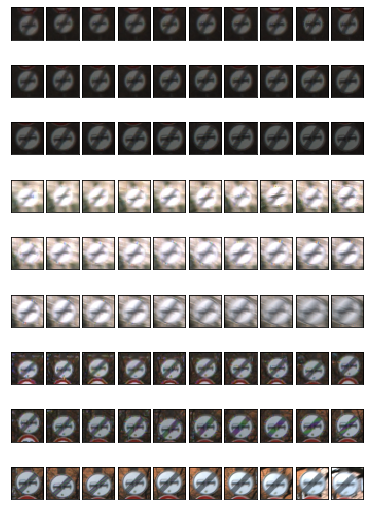

In [14]:
# visualize consecutive training data images
# visualize consecutive testing data images

# let's also display some consecutive images
plot_images(x_train, 9,10)

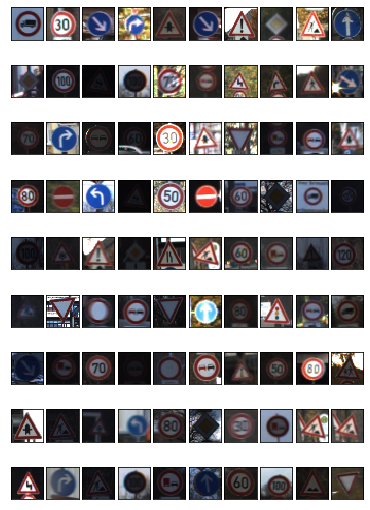

In [15]:
plot_images(x_test, 9,10)

## Define Model Architecture

### Pre Process the Dataset

In [16]:
# do you recall the pre-processing we did for mnist?
# do we need to do something similar here?


def normalizeImages(images):
    images = images.astype('float32')
    images /= 255
    return images

def one_hot_encoding(original_labels, number_of_classes):
    encoded_labels = np.zeros((len(original_labels), number_of_classes))
    for i in range(len(original_labels)):
        encoded_labels[i, original_labels[i]] = 1.
    return encoded_labels

X_train = normalizeImages(x_train)
Y_train = one_hot_encoding(y_train,n_classes)

X_test = normalizeImages(x_test)
Y_test = one_hot_encoding(y_test,n_classes)

print("Training images:", X_train.shape, " labels:", Y_train.shape)
print("Testing images:", X_test.shape, " labels:", Y_test.shape)

Training images: (34799, 32, 32, 3)  labels: (34799, 43)
Testing images: (12630, 32, 32, 3)  labels: (12630, 43)


### Create the Model

Try to build the building blocks you learned about.

Convolution 2D layers, Activations, Pooling Layers, Dropout

At the end use a couple of Dense Layers

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Dense, Convolution2D, ReLU, MaxPooling2D, Flatten, Dropout, Activation 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

model = Sequential()
# normalize input to (-1, 1)
model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(img_rows, img_cols, 3), name='Normalization'))
model.add(Convolution2D(32, (3, 3), input_shape=(img_rows, img_cols), name='Conv1'))
model.add(ReLU())
model.add(Convolution2D(32, (3, 3), name='Conv2'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool1"))
model.add(Dropout(0.5, name="Dropout_0.5_1"))

model.add(Convolution2D(64, (3, 3), padding='same', name='Conv3'))
model.add(ReLU())
model.add(Convolution2D(64, (3, 3), name='Conv4'))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool2"))
model.add(Dropout(0.5, name="Dropout_0.5_2"))

model.add(Flatten(name="Flatten"))
model.add(Dense(512, name="Dense512"))
model.add(ReLU())
model.add(Dropout(0.5, name="Dropout_0.5_3"))
model.add(Dense(1, name="Output"))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization (Lambda)       (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
re_lu (ReLU)                 (None, 30, 30, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 28, 32)        9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
Dropout_0.5_1 (Dropout)      (None, 14, 14, 32)      

### Train, Validate and Test